# Mini-projet Groupe 1 : Charge d'une flotte de véhicules électriques

# Corentin Loirs et Juliette Gerbaux

## 1. Modélisation

### Question 1 :

On suppose que les batteries des voitures sont identiques. Notons le taux de charge relative $\tau\,=\,\frac{q}{q_{max}}$ où $q$ est la charge absolue de la batterie, $q_{max}$ la charge absolue maximale et $P$ la puissance fournie à la batterie. 

On suppose qu'il y a toujours assez de bornes de recharge pour les voitures qui souhaitent être rechargées. On note $n$ le nombre de voitures et pour chaque voiture $j$ le temps $t^0_j$ d'arrivée et $t^f_j$ le temps de départ ainsi que $\tau^0_j$ et $\tau^f_j$ les taux de charge relatifs à l'arrivée et au départ.

Notons $f$ la fonction objectif du problème qui est le coût de recharge lié à la consommation électrique qui dépend de l'intensité $I_j$ qui parcourt chaque borne de recharge $j$ à tout instant.
    
$f(I)\,=\,\int^{t_f}_{t_0}\sum_{j=1}^nI_j(t)\,Up(t)dt$ où $t_0 = \displaystyle \max_{j}(t^0_j)$, $t_f = \displaystyle \max_{j}(t^f_j)$, $U$ la tension du réseau (que l'on suppose fixe égale à $230 V$) et $p(t)$ est le prix de l'électricité en euros/$kWh$.

### Question 2 :

On a : $\frac{dq}{dt}(t) = \alpha\,I(t) = \alpha\,\frac{P(t)}{U}$ d'où : $\frac{d\tau}{dt}(t) =\alpha\, \frac{P(t)}{U*q_{max}} = \alpha\, \frac{I(t)}{q_{max}}$ où $\alpha$ est un facteur lié aux pertes diverses de charge (effet Joule, cablage...) à déterminer expérimentalement. 

### Question 3 :

On va ici traiter de l'évaluation expérimentale de notre modèle, i.e. le calcul par la régression (linéaire dans notre cas, puisque la relation $\frac{dq}{dt}(I)$ est linéaire). On trace d'après les données fournies $\frac{dq}{dt}(t)$ en fonction de $I(t)$.

Etant donné que du bruit a été ajouté aux données et qu'on a accès à $q(t)$ et non $\frac{dq}{dt}(t)$, on va tenter deux méthodes de régression : 
* La première consiste à extrapoler $\frac{dq}{dt}(t)$ d'après les données et tracer cette approximation en fonction de $I(t)$ donné
* La seconde consiste à intégrer $I(t)$ par méthode numérique et tracer $q$ en fonction de  $\int I$.

Dans les deux cas, on aura un coefficient de régression qui vaudra (si tant est que le modèle linéaire est juste) $\frac{\alpha}{q_{max}}$.

In [1]:
#traitement des données, mise en forme sous un panda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

table = pd.read_table('donnees-projet-gr1.txt', names=['temps', 'intensité', 'charge_relative'])
table.head()

,temps,intensité,charge_relative
0,0.000000,0.005755,0.626524
1,1.005016,0.018529,0.631323
2,2.008215,-0.022398,0.629266
3,3.018137,0.008812,0.631987
4,4.023168,0.003566,0.632518


##### Par le calcul de la dérivée

In [2]:
### On calcule la dérivée de la charge
table_der = table.copy(deep = True)
table_der['derivee_charge'] = 0
for i in table_der.index :
    if i == 0:
        table_der.iloc[i, 3] = 0
    else :
        table_der.iloc[i, 3] = (table_der.iloc[i-1, 2] - table_der.iloc[i, 2])/(table_der.iloc[i-1, 0] - table_der.iloc[i, 0])
table_der.drop([0], inplace = True) ### On supprime la première ligne car on a pas la dérivée de la charge pour cette ligne.
table_der.head()

,temps,intensité,charge_relative,derivee_charge
1,1.005016,0.018529,0.631323,0.004775
2,2.008215,-0.022398,0.629266,-0.002050
3,3.018137,0.008812,0.631987,0.002694
4,4.023168,0.003566,0.632518,0.000529
5,5.027335,-0.012886,0.632880,0.000360


In [3]:
### On crée notre fonction objectif
def f(a):
    s = 0
    for i in table_der.index :
        s += (table_der.loc[i, 'derivee_charge'] - a*table_der.loc[i, 'intensité'] )**2
    return s

In [4]:
from scipy.optimize import minimize_scalar
res = minimize_scalar(f)
res

     fun: 0.002029256395442698
    nfev: 27
     nit: 23
 success: True
       x: 0.0019426071168044741

On trouve donc que $\frac{d\tau}{dt} = 0.00194 \times I$ avec une erreur de 0.00203.

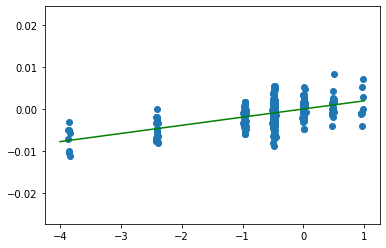

In [5]:
plt.scatter(table_der['intensité'], table_der['derivee_charge'])
x = np.linspace(-4, 1)
plt.plot(x, 0.0019426071168044741*x, 'g')

Remarquons d'abord que cette régression ne semble pas très précise: la méthode des moindres carrés fait passer la droite par la moyenne quadratique des bruits. Etant donné que le bruit a été rajouté artificiellement, on peut se douter que la moyenne quadratique donne une bonne indication de la valeur réelle. Cependant, si l'on avait un bruit pondéré (par exemple avec beaucoup de marge vers le bas) ou borné, la valeur du coefficient de régression inspirerait peut de confiance.

Pour valider ce résultat (ou l'infirmer), on va passer par une méthode d'intrégration.

##### Par intégration

In [6]:
### On intègre I par la méthode des trapèzes
table_int = table.copy(deep = True)
table_int['int_I'] = 0
for i in table_int.index :
    if i == 0 : ### Calcul de l'intégrale entre t0 et t1
        table_int.iloc[i, 3] = (table_int.iloc[i+1, 0] - table_int.iloc[i, 0])*(table_int.iloc[i, 1] + table_int.iloc[i, 1])/2
    elif i!=298 : ### On calcule l'intégrale de I entre ti et t(i+1) et on ajoute la valeur de l'intégrale entre t0 et ti
        table_int.iloc[i, 3] = table_int.iloc[i-1,3]+(table_int.iloc[i+1, 0] - table_int.iloc[i, 0])*(table_int.iloc[i, 1] + table_int.iloc[i, 1])/2
    else : ### On ne peut pas caluler la dernière intégrale
        table_int.iloc[i, 3] = 0
table_int.drop([298], inplace = True) ###La dernière valeur n'a pas de sens.
table_int.head()

,temps,intensité,charge_relative,int_I
0,0.000000,0.005755,0.626524,0.005784
1,1.005016,0.018529,0.631323,0.024373
2,2.008215,-0.022398,0.629266,0.001753
3,3.018137,0.008812,0.631987,0.010609
4,4.023168,0.003566,0.632518,0.014190


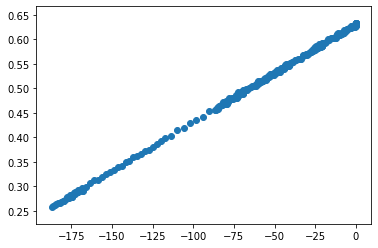

In [7]:
plt.scatter(table_int['int_I'], table_int['charge_relative'])

In [8]:
### On crée notre nouvelle fonction objectif
def g(a):
    s = 0
    for i in  table_int.index :
        s += (table_int.loc[i, 'charge_relative'] - a*table_int.loc[i, 'int_I'] - table_int.loc[0, 'charge_relative'])**2
    return s

In [9]:
from scipy.optimize import minimize_scalar
res = minimize_scalar(g)
res

     fun: 0.00315681526792678
    nfev: 9
     nit: 5
 success: True
       x: 0.0019568267225706162

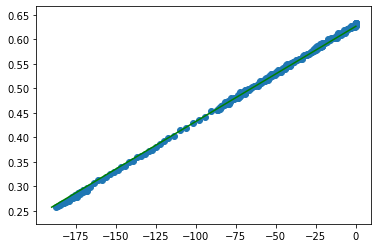

In [10]:
plt.scatter(table_int['int_I'], table_int['charge_relative'])
x = np.linspace(-190, 0)
plt.plot(x, 0.0019426071168044741*x + table_int.loc[0, 'charge_relative'], 'g')

Ce graphe est nettement plus satisfaisant: on retrouve bien une relation affine de la forme $ q = a \int I+q_0$.
On retrouve le même coefficient directeur, qui vaut environ 0.0020. 

On valide donc le modèle proposé, soit $\frac{d\tau}{dt}\,=\,\frac{\alpha}{q_{max}}\times I$ avec $\frac{\alpha}{q_{max}}=0,002$

### Question 4 :

#### Contraintes du problème

Nous avons donc la fonction objectif du problème $f$ qu'il faut minimiser en fonction du vecteur $I$ des instensités. Ecrivons à présent les contraintes du porblème. 

- $I_j(t) = 0$ pour $t \notin [t_j^0, t_j^f]$ pour tout $j$ : la voiture ne peut pas charger si elle n'est pas là.
- $\tau_j(t) \in [0, 1]$ pour tout $t$ et tout $j$ : le taux de charge relatif est compris entre 0 et 1. (deux conditions en une)
- $\tau_j(t_j^0) = \tau^0_j$ pour tout $j$ : le taux de charge de la voiture $j$ lorsque la voiture arrive est égal à la charge initial.
- $\tau_j(t_j^f) \geq \tau^f_j$ pour tout $j$ : le taux de charge de la voiture $j$ lorsque la voiture part est supérieur ou égal au taux de charge final voulu.
- $\sum_{j=1}^n I_j(t)U \leq P_{max}$ pout tout $t$ : la puissance fournie à tout instant $t$ aux voitures ne dépasse pas la puissance maximale $P_{max}$ du réseau. 
- $\frac{d\tau_j(t)}{dt}\,=\,\frac{\alpha}{q_{max}}\times I_j(t)$ avec $\frac{\alpha}{q_{max}}=0,002$ pour tout $t$ et tout $j$.

#### Version discrète du problème

On peut ensuite passer à une version discrétisée du problème pour avoir un problème d'optimisation sous contraintes en dimension finie : 

On commence par discrétiser le temps en $N$ pas. On pose $T_0 = t_0$ et $T_k = T_0 + k\times \Delta T$ où $\Delta T = \frac{t_f - t_0}{N}$ de sorte que $T_N = t_f$. On choisit de réécrire les temps d'arrivée et de départ d'une voiture $j$, $t_j^0 = T_{k_j^0}$ et $t_j^f = T_{k_j^f}$.

Ensuite, on reécrit notre fonction objectif : $f(I) = \sum_{k=0}^{N-1} \sum_{j=1}^n I_j(T_k)\times U \times p(T_k)\Delta T$ (on a intégré selon la méthodes des rectangles à gauche).

Et enfin, nos contraintes :
- $I_j(T_k) = 0$ pour $T_k \notin [T_{k_j^0},T_{k_j^f}]$ ou encore pour tout $k \notin [\![k_j^0, k_j^f ]\!]$ et pour tout $j$: la voiture ne peut pas charger si elle n'est pas là.
- $\tau_j(T_k) \in [0, 1]$ pour tout $k$ et tout $j$ : le taux de charge relatif est compris entre 0 et 1. (deux conditions en une)
- $\tau_j(T_{k_j^0}) = \tau^0_j$ pour tout $j$ : le taux de charge de la voiture $j$ lorsque la voiture arrive est égal à la charge initial.
- $\tau_j(T_{k_j^f}) \geq \tau^f_j$ pour tout $j$: le taux de charge de la voiture $j$ lorsque la voiture part est supérieur ou égal au taux de charge final voulu.
- $\sum_{j=1}^n I_j(T_k)U \leq P_{max}$ pout tout $k$ : la puissance fournie à tout instant aux voitures ne dépasse pas la puissance maximale $P_{max}$ du réseau. 
- $\tau_j(T_{k+1})\,=\,\tau_j(T_{k}) + \frac{\alpha}{q_{max}}\times I_j(T_k)$ avec $\frac{\alpha}{q_{max}}=0,002$ pour tout $k$ et tout $j$.

##### Version avec des matrices

On peut aussi réécrire ce problème en utilisant trois matrices et la norme 1 sur $R^n$. 

On utilise la matrice I des intensités telle que $I_{j,k} = I_j(T_k)$, la matrice colonne P des prix telle $P_k = p(T_k)$ et la matrice $\tau$ des charges relatives telle que $\tau_{j,k} = \tau_j(T_k)$.

La fonction objectif est alors : $f(I) = U\times \Delta T \times||I\times P||_1$ (cette relation n'est valable que lorsque tous les coefficients de $I$ sont positifs).

Et les contraintes s'écrivent :
- $I_{j,k} = 0$ pour tout $j$ et pour tout $k \notin [\![k_j^0, k_j^f ]\!]$ 
- $\tau_{j,k} \in [0, 1]$ pour tout $k$ et tout $j$ 
- $\tau_{j,k_j^0} = \tau^0_j$ pour tout $j$ 
- $\tau_{j,k_j^f} \geq \tau^f_j$ pout tout $j$
- $||U\times I_k||_1\leq P_{max}$ pout tout $k$ où $I_k$ est la $k^{ème}$ colonne de $I$.
- $\tau_{j,k+1}\,=\,\tau_{j,k} + \frac{\alpha}{q_{max}}\times I_{j,k}$ avec $\frac{\alpha}{q_{max}}=0,002$ pour tout $k$ et tout $j$.

## 2. Etude et résolution numérique 

A partir de maintenant, on choisit de garder les notations et la modélisation de la correction. 

On discrètise le temps en $N$ pas. Pour une seule voiture, la fonction à minimiser est : $f(w) = p^T\times w$ où $w$ est un vecteur de $\mathbb{R}^N$ qui représente la puissance fournie à la voiture au cours du temps et $p$ est la matrice des prix. Les contraintes sont $\Delta q = b_0 1^T_{[n_0, n_f]} w$ et $0 \leq w \leq w_{max}$ où $b_0$ est une constante telle que $\frac{b_0 U}{q_{max}}=0.002$, $n_0$ et $n_f$ représentent les temps d'arrivée et de départ de la voiture et $w_{max}$ la puissance maximale du parc de bornes de recharge.

### Question 1 :

La fonction f est bien convexe car linéaire. Les contraintes sont aussi linéaires donc les contraintes sont convexes. La condition $0 \leq w \leq w_{max} $ implique que l'on travaille sur un fermé donc que la fonction $f$ (qui est continue) admet bien un minumum. 

En revanche, on ne peut rien dire sur l'unicité du minimum, par exemple dans le cas $N = 2$, si $p = (1, 1)$, $w_{max} = 2$, $n_0 = 1, n_f = 2$, on peut avoir une solution unique ou pas en fonction de la charge souhaitée. Si $\frac{\Delta q}{b_0}$ est égal à 4 alors la solution est unique égale à $(2, 2)$ alors que si $\frac{\Delta q}{b_0}$ vaut 3, on a une infinité de solutions. La solution est unique que si on a exactement le temps de charger la voiture en fournissant la puissance maximale à chaque fois. On peut supposer que la plupart du temps, ce ne sera pas le cas et donc que le nombre de solutions sera infini. 

On peut réécrire le problème sous forme d'un problème quadratique avec contraintes affines : 
- $f(w) = w^T\times p$
- $ c(w) = Aw - b \leq 0 $est une matrice à $2N+1$ lignes et $N$ colonnes $A =$ \begin{bmatrix} -I_N\\ I_N \\ - 1^T_{[n_0, n_f]} \end{bmatrix} et $b$ est une matrice colonne à $2N+1$ linges : $b=$ \begin{bmatrix} 0\\ ... \\0 \\ w_{max} \\ ... \\ w_{max} \\ -\frac{\Delta q}{b_0} \end{bmatrix}

En effet, on peut tranformer la contrainte $\Delta q = b_0 1^T_{[n_0, n_f]} w$ en une contrainte inégalité $ b_0 1^T_{[n_0, n_f]} w -\Delta q \geq 0 $ qui sera nécessairement active pour minimiser $f$ car $p$ et $w$ sont positifs donc on n'a pas intéret à charger plus que ce qui est demandé.

On peut donc réssoudre ce problème avec un algorithme de type contraintes actives.

### Question 2 :

On choisit de discrétiser le temps $N = 144$ pas de temps de 10 minutes. Le prix horraire du kWh est en première approximation égal à 0.15 euros. On considère que la voiture arrive à $n_0 = 540$ minutes (9h) et repart à $n_f = 720$ minutes (12h). On prend $w_{max} = 1 kW$. On choisit aussi $\frac{\Delta q}{b_0} = \Delta \tau \frac{q_{max}}{b_0} = \frac{0.7\times 230}{0.002}$. 

Nous allons cependant traiter une version plus simple dans un premier temps.

In [11]:
import numpy as np 
import time 
import matplotlib.pyplot as plt

def matrice_contrainte(N, n0, nf, w_max, charge): #renvoie les matrices A et b associés au paramètres du problème
    I_N = np.identity(N)
    matrice_1 = np.zeros((1,N))
    for i in range(N):
        if n0 <= i <= nf :
            matrice_1[0, i] = -1
    A = np.concatenate((-I_N, I_N))
    A = np.concatenate((A, matrice_1))

    b = np.zeros(2*N+1)
    for i in range(2*N+1):
        if i >= N :
            b[i] = w_max
            b[-1] = -charge
    b = b.reshape((2*N+1,1))
    return A, b
        


In [12]:
def direction_des(N, A, p, C): # on construit une direction de descente à partir du procédé d'orthogonalisation de Schmidt 
    ortho = (np.linalg.qr(A[C].T)[0]).T
    s = np.zeros(N)# on rajoute ensuite un vecteur qui est -p projeté sur l'orthogonal de vecteurs a_i, i in C qui est aussi
    for k in ortho:                           # l'orthogonal de vecteurs de la base précédente
        s += -np.dot(-p.T,k)[0]*k
    return (-p.T + s).T

    

def alpha(N, A, b, direction, C, w): #calcul un coefficient tel que x_k+1 vérifie bien les contraintes
    a = 1
    indice = -1
    for i in range(2*N+1):
        ps = np.dot(A[i], direction)[0]
        if ps != 0:
            candidat = (b[i][0]- np.dot(A[i], w)[0])/ps
            if i not in C :
                if ps > 0 and candidat < a:
                    a = candidat
                    indice = i
                elif ps < 0 and candidat > a :
                    a = candidat
                    indice = i
    return max(a, 0), indice

def positif(L): #renvoie si tous les éléments d'une liste sont positifs
    for x in L:
        if x<0:
            return False
    return True

def coef_lagrange(A, p, C): #calcule les coefs de Lagrange associées au contraintes C
    Atilde = A[C].T
    sol = np.linalg.lstsq(Atilde, -p, rcond=None)
    return sol[0]

In [13]:
def contrainte_active(N, p, n0, nf, w_max, charge, w0, C0, aff = False):
    A, b = matrice_contrainte(N, n0, nf, w_max, charge)
    w = w0
    C = C0
    epsilon = 100*np.finfo(float).eps
    while True:
        debut = time.time()
        if aff : print(f'w={w.T}, C={C}')
        print('==== Nouvelle itération ====')
        direction = direction_des(N, A, p, C) #on trouve une direction de descente
        fin = time.time()

        print(f'temps mis pout chosir une direction : {fin -debut} s')
        
        if not np.all(np.abs(direction) <= epsilon): #cas où pk est non nul
            debut = time.time()
            a, indice = alpha(N, A, b, direction, C, w)
            if aff : print(f'a={a}, indice={indice}, direction={direction.T}')
            w = w + a*direction #on met à jour w
            if a < 1 :
                C.append(indice) #ainsi que les contraintes actives si jamais une contrainte est bloquante
                C.sort()
            fin = time.time()
            print(f'pk est non nul et + contrainte {indice} en {fin - debut} s')
        
        else : #cas où pk est nul
            debut = time.time()
            coef = coef_lagrange(A, p, C)
            if positif(coef): #on a trouvé le minumum ! (d'après KKT)
                return w
            indice = 0
            mini = coef[0]
            for i, x in enumerate(coef) : #on enlève la contrainte avec le plus petit coeff de lagrange
                if x < mini :
                    mini = x
                    indice = i
            fin = time.time()
            print(f'pk est nul et - contrainte {C[indice]} en {fin - debut} s')
            C.pop(indice)
            
            
            

##### Version trés simplifée

In [14]:
debut = time.time()
N = 10
p = np.ones((N, 1)) ## prix de 1 constant
n0 = 3
nf = 8
w_max = 2
charge = 7
w0 = np.ones((N, 1))*w_max
C0 = [i for i in range(N, 2*N)]
w = contrainte_active(N, p, n0, nf, w_max, charge, w0, C0, aff = True)
fin = time.time()

w=[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], C=[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.019127368927001953 s
pk est nul et - contrainte 10 en 0.024739980697631836 s
w=[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], C=[11, 12, 13, 14, 15, 16, 17, 18, 19]
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
a=1, indice=-1, direction=[[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
pk est non nul et + contrainte -1 en 0.0 s
w=[[1. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], C=[11, 12, 13, 14, 15, 16, 17, 18, 19]
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
a=1, indice=-1, direction=[[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
pk est non nul et + contrainte -1 en 0.0 s
w=[[0. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], C=[11, 12, 13, 14, 15, 16, 17, 18, 19]
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
a=0.0, indice=0, direction=[[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
pk est non nul et + contrainte

La solution est [[0. 0. 0. 0. 0. 1. 2. 2. 2. 0.]], pour les conditions : N=10, prix=1, n0=3, nf=8, w_max=2, charge=7 en 0.0962667465209961 s


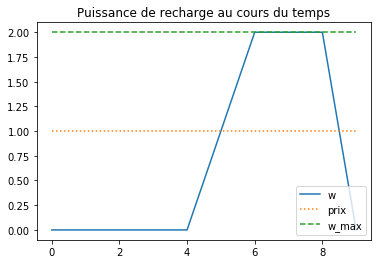

In [15]:
plt.plot(w, label ='w')
plt.plot(p, ':', label='prix')
plt.plot(np.ones(N)*w_max, '--', label='w_max')
plt.legend()
plt.title('Puissance de recharge au cours du temps')
print(f'La solution est {w.T}, pour les conditions : N={N}, prix=1, n0={n0}, nf={nf}, w_max={w_max}, charge={charge} en {fin -debut} s')

##### Version plus réaliste

On prend maintenant les valeurs définies au début de la question. Pour plus de simplicité, on exprime les prix en centimes et les puissances en kW. 

In [27]:
debut = time.time()
N = 144
p = 15*np.ones((N, 1)) ## prix de 15 centimes
n0 = 54
nf = 72
w_max = 1
charge = 0.7*230/(0.002*1000)/10
C0 = []
w0 = np.zeros((N, 1))
for t in range(N): 
    if n0 <= t <= nf :
        w0[t, 0] = w_max
        C0.append(N + t)
    else :
        C0.append(t)
### on commence avec w nul lorsque la voiture n'est pas là et égal à w_max lorsqu'elle est là.
w = contrainte_active(N, p, n0, nf, w_max, charge, w0, C0 )
fin = time.time()

==== Nouvelle itération ====
temps mis pout chosir une direction : 0.011859893798828125 s
pk est nul et - contrainte 198 en 0.005634784698486328 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte 54 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est nul et - contrainte 199 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.017046213150024414 s
pk est non nul et + contrainte 55 en 0.0009944438934326172 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est nul et - contrainte 200 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte 56 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est nul et - contrainte 201 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte 57 en 0.0 s
==== Nouvelle i

Conditions : N=144, n0=54, nf=72, w_max=1, charge=8.05, calcul en 0.20176434516906738 s


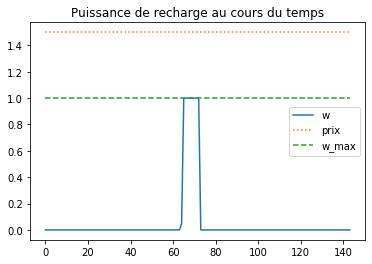

In [28]:
plt.plot(w, label ='w')
plt.plot(p/10, ':', label='prix')
plt.plot(np.ones(N)*w_max, '--', label='w_max')
plt.legend()
plt.title('Puissance de recharge au cours du temps')
print(f'Conditions : N={N}, n0={n0}, nf={nf}, w_max={w_max}, charge={charge}, calcul en {fin -debut} s')

##### Version avec prix variable

In [31]:
debut = time.time()
N = 144
p = np.zeros((N, 1)) ## prix variable
for i in range(N):
    if i <= 7*6 or i> 23*6 :
        p[i][0] = 13.37
    else : 
        p[i][0] = 17.81 

n0 = 36
nf = 54
w_max = 1
charge = 0.7*230/(0.002*1000)/10
C0 = []
w0 = np.zeros((N, 1))
for t in range(N): 
    if n0 <= t <= nf :
        w0[t, 0] = w_max
        C0.append(N + t)
    else :
        C0.append(t)
### on commence avec w nul lorsque la voiture n'est pas là et égal à w_max lorsqu'elle est là.
w = contrainte_active(N, p, n0, nf, w_max, charge, w0, C0 )
fin = time.time()

==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01168513298034668 s
pk est nul et - contrainte 187 en 0.0023343563079833984 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte 43 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est nul et - contrainte 198 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.016094684600830078 s
pk est non nul et + contrainte 54 en 0.0018694400787353516 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0009980201721191406 s
pk est nul et - contrainte 195 en 0.006928443908691406 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0036351680755615234 s
pk est non nul et + contrainte 51 en 0.0009937286376953125 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0009975433349609375 s
pk est nul et - contrainte 193 en 0.0 s
==== Nouvelle itération ====
temps mis pou

Conditions : N=144, n0=36, nf=54, w_max=1, charge=8.05, calcul en 0.18249011039733887 s


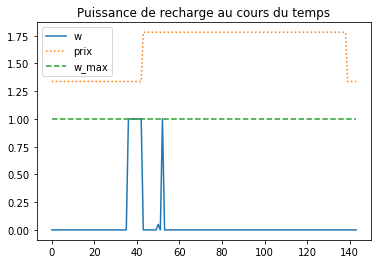

In [32]:
plt.plot(w, label ='w')
plt.plot(p/10, ':', label='prix')
plt.plot(np.ones(N)*w_max, '--', label='w_max')
plt.legend()
plt.title('Puissance de recharge au cours du temps')
print(f'Conditions : N={N}, n0={n0}, nf={nf}, w_max={w_max}, charge={charge}, calcul en {fin -debut} s')

## 3. Etude avancée

### Question 3 : 

Avec $n$ voitures, on peut utiliser une méthode de décomposition-coordination. En effet, la fonction objectif est $f(w_1, ... , w_n) = \sum_{i=1}^n p^T w_i = \sum_{i=1}^n f_i(w_i)$ où $w_i$ est la matrice de la puissance fournie à la voiture $i$ et $f_i(w_i) = p^T w_i$.

Comme dans la partie précédente, on peut réécrire la contrainte $\Delta q_i = b_0 1^T_{[n_{i,0}, n_{i,f}]} w_i$ en tant que contrainte inégalité en considérant qu'elle sera forcément active puisque $w_i$ et $p$ sont positifs : $b_0 1^T_{[n_{i,0}, n_{i,f}]} w_i - \Delta q_i  \geq 0$. Cette dernière contrainte que l'on va appeler contrainte $\alpha$ s'écrit donc $c^\alpha(w_1, ... w_n) = -D w + Q \leq 0$ où $w$ est la matrice colonne des concaténations des $w_i$, $D$ est la matrice te taille $n\times nN$ définie par blocs : 
\begin{equation}D =\begin{bmatrix} D_1 & \cdots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \cdots & D_n \end{bmatrix} \end{equation}
où $ D_i = 1^T_{[n_{i,0}, n_{i,f}]} $
et $Q$ est la matrice colonne des $\frac{\Delta q_i}{b_0}$. Cette contrainte se réécrit $c^\alpha(w_1, ... w_n) = \sum_{i=1}^n D \phi_i(w_i) - \psi_i(Q) = \sum_{i=1}^n c_i^\alpha(w_i) \leq 0$ où $c_i^\alpha(w_i) = D \phi_i(w_i) - \psi_i(Q)$ et où $\phi_i(w_i)$ est une matrice colonne à $nN$ lignes égale à 
\begin{bmatrix} 0 \\ ... \\ 0 \\ w_i \\ 0 \\ ... \\ 0 \end{bmatrix} et 
\begin{equation} \psi_i(Q) = \begin{bmatrix} 0 \\ ... \\ 0 \\ \frac{\Delta q_i}{b_0} \\ 0 \\ ... \\ 0 \end{bmatrix} \end{equation}

La contrainte $\beta : -w_i \leq 0$ s'écrit $c^\beta (w_1, ..., w_n) = - I_{nN} w \leq 0$  ou encore $c^\beta(w) = \sum_{i=1}^n c_i^\beta(w_i)$ où $c_i^\beta(w_i) = -  I_{nN} \phi_i(w_i)$.

La contrainte $\gamma: \sum_{i=1}^n w_i - w_{max} \leq 0$ s'écrit $c^\gamma (w_1, ..., w_n) = C w - W \leq 0$ où $C$ est la matrice est une matrice à $N$ lignes et $nN$ colonnes : 
\begin{equation} C= \begin{bmatrix} I_N &... &I_N \end{bmatrix} \end{equation}
et $W$ est la matrice colonne à $N$ lignes où chaque coefficient est égal à $w_{max}$. On a donc : $c^\gamma (w_1, ..., w_n)  = \sum_{i=1}^n c_i^\gamma (w_i)$ où $c_i^\gamma (w_i) = C\phi_i(w_i) - \frac{1}{n}W$.

La contrainte globale sur $w$ s'écrit donc : $c(w) = Aw-b$ où \begin{equation} A = \begin{bmatrix} -D \\ -I_{nN} \\ C \end{bmatrix} \end{equation} et \begin{equation} b = \begin{bmatrix}- Q \\ 0 \\ ... \\ 0 \\ W  \end{bmatrix} \end{equation}
($A$ est une matrice à $n  + nN + N$ lignes et $nN$ colonnes, $b$ est une matrice colonne à $n  + nN + N$ lignes)

Cette contrainte se réécrit : $c(w) = \sum_{i=1}^n A\phi_i(w_i) -b_i = \sum_{i=1}^n c_i(w_i) $ où $c_i(w_i) =  A\phi_i(w_i) -b_i$ et où  \begin{equation}b_i = \begin{bmatrix} \psi_i(Q) \\ 0 \\ ... \\ 0 \\ \frac{1}{n}W \end{bmatrix} \end{equation}

Le problème s'écrit donc : 
\begin{equation} f(w) = \sum_{i=1}^n f_i(w_i) , f_i(w_i) = p^T w_i \end{equation}
\begin{equation} c(w) = \sum_{i=1}^n c_i(w_i) , c_i(w_i) = A\phi_i(w_i) -b_i \end{equation}
Et on pourrait utiliser une méthode de décomposition-coordination. Cependant, on résolverait un problème plus restreint que celui proposé puisque la puissance alouée à chaque voiture ne peut pas dépasser w_max sur le nombre de voitures. On préfère réutiliser l'algorithme de la partie précédente que l'on modofie légérement pour qu'il s'adapte à plusieurs voitures.

### Question 4 :

In [33]:
def matrice_contrainte2(N, n, n0, nf, w_max, charge):
    I_nN = np.identity(n*N)
    D = np.zeros((n,n*N))
    for j in range(n):
        for i in range(N):
            if n0[j] <= i<= nf[j] :
                D[j, i+j*N] = -1
    C = np.concatenate((np.identity(N), np.identity(N)), axis = 1)
    for j in range(n-2):
        C = np.concatenate((C, np.identity(N)), axis = 1)
    A = np.concatenate((D, -I_nN))
    A = np.concatenate((A, C))
    b = np.zeros((n + n*N + N, 1))
    for j in range(n):
        for i in range(N + n*N + n):
            if i ==j:
                b[i, 0] = -charge[j]
            elif i >= n + n*N :
                b[i, 0] = w_max
    return A, b



In [34]:
def direction_des2(N, n, A, p, C): # on construit une direction de descente à partir du procédé d'orthogonalisation de Schmidt 
    ortho = (np.linalg.qr(A[C].T)[0]).T
    s = np.zeros(N*n)# on rajoute ensuite un vecteur qui est -p projeté sur l'orthogonal de vecteurs a_i, i in C qui est aussi
    for k in ortho:                           # l'orthogonal de vecteurs de la base précédente
        s += -np.dot(-p.T,k)[0]*k
    return (-p.T + s).T

    

def alpha2(N, n, A, b, direction, C, w): #calcul un coefficient tel que x_k+1 vérifie bien les contraintes
    a = 1
    indice = -1
    for i in range(n + n*N + N):
        ps = np.dot(A[i], direction)[0]
        if ps != 0:
            candidat = (b[i][0]- np.dot(A[i], w)[0])/ps
            if i not in C :
                if ps > 0 and candidat < a:
                    a = candidat
                    indice = i
                elif ps < 0 and candidat > a :
                    a = candidat
                    indice = i
    return max(a, 0), indice

def positif(L): #renvoie si tous les éléments d'une liste sont positifs
    for x in L:
        if x<0:
            return False
    return True

def coef_lagrange(A, p, C): #calcule les coefs de Lagrange associées au contraintes C
    Atilde = A[C].T
    sol = np.linalg.lstsq(Atilde, -p, rcond=None)
    return sol[0]

In [35]:
def contrainte_active2(N, n, p, n0, nf, w_max, charge, w0, C0, aff = False):
    A, b = matrice_contrainte2(N, n, n0, nf, w_max, charge)
    w = w0
    C = C0
    epsilon = 100*np.finfo(float).eps
    while True:
        debut = time.time()
        if aff : print(f'w={w.T[:30]}, C={C[:30]}')
        print('==== Nouvelle itération ====')
        direction = direction_des2(N, n, A, p, C) #on trouve une direction de descente
        fin = time.time()

        print(f'temps mis pout chosir une direction : {fin -debut} s')
        
        if not np.all(np.abs(direction) <= epsilon): #cas où pk est non nul
            debut = time.time()
            a, indice = alpha2(N, n, A, b, direction, C, w)
            if aff : print(f'a={a}, indice={indice}, direction={direction.T[:30]}')
            w = w + a*direction #on met à jour w
            if a < 1 :
                C.append(indice) #ainsi que les contraintes actives si jamais une contrainte est bloquante
                C.sort()
            fin = time.time()
            print(f'pk est non nul et + contrainte {indice} en {fin - debut} s')
        
        else : #cas où pk est nul
            debut = time.time()
            coef = coef_lagrange(A, p, C)
            if positif(coef): #on a trouvé le minumum ! (d'après KKT)
                return w
            indice = 0
            mini = coef[0]
            for i, x in enumerate(coef) : #on enlève la contrainte avec le plus petit coeff de lagrange
                if x < mini :
                    mini = x
                    indice = i
            fin = time.time()
            print(f'pk est nul et - contrainte {C[indice]} en {fin - debut} s')
            C.pop(indice)

##### Version simple (pour vérifer que le programme marche bien)

In [36]:
debut = time.time()
N = 10
n = 3
p = np.zeros((N*n, 1))
for i in range(n*N):
    if i%N >= 4 :
        p[i, 0] = 1.5
    else :
        p[i, 0] = 1
n0 = [2, 5, 0]
nf = [7, 9, 9]
w_max = 2
charge = [4, 3, 5]
w0 = np.zeros((N*n, 1))
C0 = []
for i in range(N):
    voiture_presente = []
    for j in range(n):
        if n0[j]<= i <= nf[j]:
            voiture_presente.append(j)
    if voiture_presente != []:
        C0.append(n + n*N + i)
    for j in range(n):
        if j in voiture_presente :
            w0[i + N*j, 0] = w_max/len(voiture_presente)
        else :
            w0[i + N*j, 0] = 0
            C0.append(n + j*N + i)
C0.sort()
w = contrainte_active2(N, n, p, n0, nf, w_max, charge, w0, C0, aff = True) ## matrice_contrainte2(N, n, n0, nf, w_max, charge)
fin = time.time()

w=[[0.         0.         1.         1.         1.         0.66666667
  0.66666667 0.66666667 0.         0.         0.         0.
  0.         0.         0.         0.66666667 0.66666667 0.66666667
  1.         1.         2.         2.         1.         1.
  1.         0.66666667 0.66666667 0.66666667 1.         1.        ]], C=[3, 4, 11, 12, 13, 14, 15, 16, 17, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est nul et - contrainte 41 en 0.0 s
w=[[0.         0.         1.         1.         1.         0.66666667
  0.66666667 0.66666667 0.         0.         0.         0.
  0.         0.         0.         0.66666667 0.66666667 0.66666667
  1.         1.         2.         2.         1.         1.
  1.         0.66666667 0.66666667 0.66666667 1.         1.        ]], C=[3, 4, 11, 12, 13, 14, 15, 16, 17, 33, 34, 35, 36, 37, 38, 39, 40, 42]
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.00099277496

La solution est [[-6.59125644e-16  1.48029737e-16  1.60000000e+00  1.60000000e+00
   0.00000000e+00  4.46145178e-17  3.02768594e-16  8.00000000e-01
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  4.19109192e-15  2.31516688e-16  1.20000000e+00
   9.00920549e-17  1.80000000e+00]
 [ 2.00000000e+00  2.00000000e+00  4.00000000e-01  4.00000000e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.00000000e-01]], pour les conditions : N=10, n=3, prix=1, n0=[2, 5, 0], nf=[7, 9, 9], w_max=2, charge=[4, 3, 5] en 0.0751199722290039 s


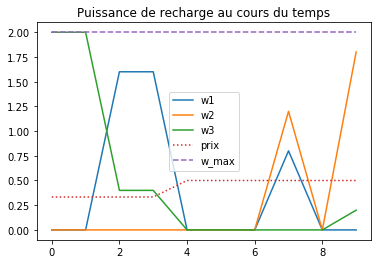

In [37]:
plt.plot(w[:N], label ='w1')
plt.plot(w[N:2*N], label ='w2')
plt.plot(w[2*N:], label ='w3')
plt.plot(p[:N]/3, ':', label='prix')
plt.plot(np.ones(N)*w_max, '--', label='w_max')
plt.legend()
plt.title('Puissance de recharge au cours du temps')
print(f'La solution est {w.reshape(n, N)}, pour les conditions : N={N}, n={n}, prix=1, n0={n0}, nf={nf}, w_max={w_max}, charge={charge} en {fin -debut} s')

In [39]:
debut = time.time()
N = 144
n = 2
p = np.zeros((N*n, 1))
for j in range(n):
    for i in range(N):
        if i <= 7*6 or i> 23*6 :
            p[i + j*N][0] = 13.37
        else : 
            p[i +j*N][0] = 17.81
n0 = [20, 50]
nf = [70, 140]
w_max = 2
charge = [0.1*230/(0.002*1000)/10, 0.3*230/(0.002*1000)/10]

w0 = np.zeros((N*n, 1))
C0 = []
for i in range(N):
    voiture_presente = []
    for j in range(n):
        if n0[j]<= i <= nf[j]:
            voiture_presente.append(j)
    if voiture_presente != []:
        C0.append(n + n*N + i)
    for j in range(n):
        if j in voiture_presente :
            w0[i + N*j, 0] = w_max/len(voiture_presente)
        else :
            w0[i + N*j, 0] = 0
            C0.append(n + j*N + i)


w = contrainte_active2(N, n, p, n0, nf, w_max, charge, w0, C0)
fin = time.time()

==== Nouvelle itération ====
temps mis pout chosir une direction : 0.008388042449951172 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.012993574142456055 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.015634536743164062 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.015620946884155273 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015620946884155273 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.016653776168823242 s
pk est non nul et + contrainte -1 en 0.0009975433349609375 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0

temps mis pout chosir une direction : 0.010924339294433594 s
pk est non nul et + contrainte -1 en 0.00703120231628418 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0020263195037841797 s
pk est non nul et + contrainte -1 en 0.003011941909790039 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.010697364807128906 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.010090112686157227 s
pk est non nul et + contrainte -1 en 0.002020120620727539 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.008041143417358398 s
pk est non nul et + contrainte -1 en 0.003009319305419922 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009056329727172852 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01246333122253418 s
pk est non nul et + contrainte -1 en 0.0055348873138427734 s
==== Nouvelle

temps mis pout chosir une direction : 0.015150070190429688 s
pk est non nul et + contrainte -1 en 0.0052607059478759766 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.026508092880249023 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01158285140991211 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.012409448623657227 s
pk est non nul et + contrainte -1 en 0.002041339874267578 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.01563286781311035 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.007830381393432617 s
pk est non nul et + contrainte -1 en 0.004789113998413086 s
==== Nouvelle itération ====
temps mis pout chosir une direction 

temps mis pout chosir une direction : 0.016631603240966797 s
pk est non nul et + contrainte -1 en 0.00817418098449707 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0009925365447998047 s
pk est non nul et + contrainte -1 en 0.015859603881835938 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01849651336669922 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.0019898414611816406 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0070688724517822266 s
pk est non nul et + contrainte -1 en 0.003404378890991211 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.008493661880493164 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une directio

temps mis pout chosir une direction : 0.015778541564941406 s
pk est non nul et + contrainte -1 en 0.0020339488983154297 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0498354434967041 s
pk est non nul et + contrainte -1 en 0.010482311248779297 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.019019126892089844 s
pk est non nul et + contrainte -1 en 0.0019903182983398438 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015905141830444336 s
pk est non nul et + contrainte -1 en 0.004355430603027344 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.008807182312011719 s
pk est non nul et + contrainte -1 en 0.010629653930664062 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0019271373748779297 s
pk est non nul et + contrainte -1 en 0.009489059448242188 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.011385440826416016 s
pk est non nul et + contrainte -1 en 0

temps mis pout chosir une direction : 0.016727209091186523 s
pk est non nul et + contrainte -1 en 0.018475770950317383 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.016761302947998047 s
pk est non nul et + contrainte -1 en 0.0030307769775390625 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.02045917510986328 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.0150604248046875 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.008857488632202148 s
pk est non nul et + contrainte -1 en 0.005013465881347656 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.010848283767700195 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.02208995819091797 s
pk est non nul et + contrainte -1 en 0.003260374069213867 s
==== Nouvelle itération ====
temp

temps mis pout chosir une direction : 0.024851322174072266 s
pk est non nul et + contrainte -1 en 0.00932765007019043 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009424686431884766 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015176534652709961 s
pk est non nul et + contrainte -1 en 0.004748821258544922 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.011134862899780273 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.012462854385375977 s
pk est non nul et + contrainte -1 en 0.005289554595947266 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009458541870117188 s
pk est non nul et + contrainte -1 en 0.004255056381225586 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.017566442489624023 s
pk est non nul et + contrainte -1 en 0.004387855529785156 s
==== Nouvelle 

temps mis pout chosir une direction : 0.0428624153137207 s
pk est non nul et + contrainte -1 en 0.008635520935058594 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.04855608940124512 s
pk est non nul et + contrainte -1 en 0.005553007125854492 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.03413963317871094 s
pk est non nul et + contrainte -1 en 0.006212472915649414 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.026398897171020508 s
pk est non nul et + contrainte -1 en 0.007156848907470703 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015333175659179688 s
pk est non nul et + contrainte -1 en 0.005049705505371094 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01213836669921875 s
pk est non nul et + contrainte -1 en 0.004622220993041992 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01604485511779785 s
pk est non nul et + contrainte -1 en 0.007176

pk est non nul et + contrainte -1 en 0.00805211067199707 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01113438606262207 s
pk est non nul et + contrainte -1 en 0.009070873260498047 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.018270492553710938 s
pk est non nul et + contrainte -1 en 0.006833791732788086 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0291745662689209 s
pk est non nul et + contrainte -1 en 0.007526397705078125 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.014756202697753906 s
pk est non nul et + contrainte -1 en 0.0029807090759277344 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.013989686965942383 s
pk est non nul et + contrainte -1 en 0.005051851272583008 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015480995178222656 s
pk est non nul et + contrainte -1 en 0.005506038665771484 s
==== Nouvelle itération ====
temps mis pout

pk est non nul et + contrainte -1 en 0.0048980712890625 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01990509033203125 s
pk est non nul et + contrainte -1 en 0.0024862289428710938 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.016666412353515625 s
pk est non nul et + contrainte -1 en 0.005950927734375 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.011928796768188477 s
pk est non nul et + contrainte -1 en 0.0044138431549072266 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.008561134338378906 s
pk est non nul et + contrainte -1 en 0.009941577911376953 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009172677993774414 s
pk est non nul et + contrainte -1 en 0.006547212600708008 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01811695098876953 s
pk est non nul et + contrainte -1 en 0.008069038391113281 s
==== Nouvelle itération ====
temps mis pout c

temps mis pout chosir une direction : 0.01863837242126465 s
pk est non nul et + contrainte -1 en 0.01745152473449707 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009035825729370117 s
pk est non nul et + contrainte -1 en 0.0035042762756347656 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009061336517333984 s
pk est non nul et + contrainte -1 en 0.011067628860473633 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.012067794799804688 s
pk est non nul et + contrainte -1 en 0.0066454410552978516 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.00892949104309082 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.020239591598510742 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015551090240478516 s
pk est non nul et + contrainte -1 en 0.004037380218505859 s
==== Nouvelle 

temps mis pout chosir une direction : 0.011993169784545898 s
pk est non nul et + contrainte -1 en 0.0055582523345947266 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.020740270614624023 s
pk est non nul et + contrainte -1 en 0.004071474075317383 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.006947994232177734 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.018167495727539062 s
pk est non nul et + contrainte -1 en 0.001993417739868164 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.013541936874389648 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.013009071350097656 s
pk est non nul et + contrainte -1 en 0.010975837707519531 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.010518074035644531 s
pk est non nul et + contrainte -1 en 0.0034813880920410156 s
==== Nouvel

temps mis pout chosir une direction : 0.017871379852294922 s
pk est non nul et + contrainte -1 en 0.008272647857666016 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0009965896606445312 s
pk est non nul et + contrainte -1 en 0.01776885986328125 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.00823831558227539 s
pk est non nul et + contrainte -1 en 0.005350828170776367 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009196996688842773 s
pk est non nul et + contrainte -1 en 0.0046939849853515625 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.011023283004760742 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01686239242553711 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chos

temps mis pout chosir une direction : 0.00836181640625 s
pk est non nul et + contrainte -1 en 0.008512735366821289 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.016809940338134766 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.022970914840698242 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015927553176879883 s
pk est non nul et + contrainte -1 en 0.0045163631439208984 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.012000322341918945 s
pk est non nul et + contrainte -1 en 0.005471944808959961 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.008373498916625977 s
pk est non nul et + contrainte -1 en 0.008087396621704102 s
==== Nouvelle itération ====
temps mis pout chosir

temps mis pout chosir une direction : 0.01182866096496582 s
pk est non nul et + contrainte -1 en 0.006069183349609375 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.011007308959960938 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.016242265701293945 s
pk est non nul et + contrainte -1 en 0.006718158721923828 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.012737035751342773 s
pk est non nul et + contrainte -1 en 0.004125356674194336 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.010579824447631836 s
pk est non nul et + contrainte -1 en 0.003299713134765625 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.003364086151123047 s
pk est non nul et + contrainte -1 en 0.009636640548706055 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009532690048217773 s
pk est non nul et + contrainte -1 en 0.002772092819213867

temps mis pout chosir une direction : 0.016811132431030273 s
pk est non nul et + contrainte -1 en 0.006726980209350586 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.008703947067260742 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015885353088378906 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.004717111587524414 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.010805130004882812 s
pk est non nul et + contrainte -1 en 0.006131649017333984 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.008141040802001953 s
pk est non nul et + contrainte -1 en 0.0033712387084960938 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.013286352157592773 s
pk est non nul et + contrainte -1 en 0.006732463836669922 s
==== Nouvelle itération ====


temps mis pout chosir une direction : 0.022631168365478516 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015984296798706055 s
pk est non nul et + contrainte -1 en 0.0034379959106445312 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009507417678833008 s
pk est non nul et + contrainte -1 en 0.006894111633300781 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.011058330535888672 s
pk est non nul et + contrainte -1 en 0.003987789154052734 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009388923645019531 s
pk est non nul et + contrainte -1 en 0.005622386932373047 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.011060714721679688 s
pk est non nul et + contrainte -1 en 0.004982709884643555 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.011029243469238281 s
pk est non nul et + contrainte -1 en 0.0060429573059082

temps mis pout chosir une direction : 0.011792421340942383 s
pk est non nul et + contrainte -1 en 0.008106231689453125 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.006857156753540039 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.00891733169555664 s
pk est non nul et + contrainte -1 en 0.010855674743652344 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01199030876159668 s
pk est non nul et + contrainte -1 en 0.003937244415283203 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.012855768203735352 s
pk est non nul et + contrainte -1 en 0.0065495967864990234 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.008898258209228516 s
pk est non nul et + contrainte -1 en 0.00802159309387207 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01578664779663086 s
pk est non nul et + contrainte -1 en 0.0054476261138916016 

temps mis pout chosir une direction : 0.022585153579711914 s
pk est non nul et + contrainte -1 en 0.009590625762939453 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.013277769088745117 s
pk est non nul et + contrainte -1 en 0.003689289093017578 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.01673603057861328 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.006735563278198242 s
pk est non nul et + contrainte -1 en 0.008677959442138672 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009463071823120117 s
pk est non nul et + contrainte -1 en 0.004998445510864258 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.002395153045654297 s
pk est non nul et + contrainte -1 en 0.014752388000488281 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0029854774475097656 s
pk est non nul et + contrainte -1 en 0.01363301277160644

pk est non nul et + contrainte -1 en 0.005600452423095703 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.007903337478637695 s
pk est non nul et + contrainte -1 en 0.0009932518005371094 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.010538578033447266 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.013459205627441406 s
pk est non nul et + contrainte -1 en 0.003988504409790039 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.010955333709716797 s
pk est non nul et + contrainte -1 en 0.001993894577026367 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01400446891784668 s
pk est non nul et + contrainte -1 en 0.0009953975677490234 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.014014005661010742 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0156

temps mis pout chosir une direction : 0.009356498718261719 s
pk est non nul et + contrainte -1 en 0.00540614128112793 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.008939981460571289 s
pk est non nul et + contrainte -1 en 0.0035393238067626953 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.010247945785522461 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01592111587524414 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.00800776481628418 s
pk est non nul et + contrainte -1 en 0.008026361465454102 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.00794363021850586 s
pk est non nul et + contrainte -1 en 0.005964756011962891 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.011318683624267578 s
pk est non nul et + contrainte -1 en 0.004952669143676758 s
==== Nouvelle it

pk est non nul et + contrainte -1 en 0.006953239440917969 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.007946252822875977 s
pk est non nul et + contrainte -1 en 0.008010387420654297 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.007976531982421875 s
pk est non nul et + contrainte -1 en 0.007972240447998047 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.00995779037475586 s
pk est non nul et + contrainte -1 en 0.0019953250885009766 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009331703186035156 s
pk est non nul et + contrainte -1 en 0.0037126541137695312 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0050961971282958984 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009442567825317383 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015

temps mis pout chosir une direction : 0.00805044174194336 s
pk est non nul et + contrainte -1 en 0.006505727767944336 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.003439188003540039 s
pk est non nul et + contrainte -1 en 0.016103029251098633 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.011989355087280273 s
pk est non nul et + contrainte -1 en 0.000995635986328125 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.017049551010131836 s
pk est non nul et + contrainte -1 en 0.005205869674682617 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.005635976791381836 s
pk est non nul et + contrainte -1 en 0.0019910335540771484 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.016001462936401367 s
pk est non nul et + contrainte -1 en 0.007980823516845703 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.006995677947998047 s
pk est non nul et + contrainte -1 en 0.

temps mis pout chosir une direction : 0.015621423721313477 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015622615814208984 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015619516372680664 s
pk est non nul et + contrainte -1 en 0.0020165443420410156 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.010275602340698242 s
pk est non nul et + contrainte -1 en 0.00099945068359375 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009062051773071289 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.010058164596557617 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.011063337326049805 s
pk est non nul et + contrainte -1 en 0.007032155990600586 s
==== Nouvelle itération ====
temps mis pout cho

temps mis pout chosir une direction : 0.009438037872314453 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009047985076904297 s
pk est non nul et + contrainte -1 en 0.011065483093261719 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.00995182991027832 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.016022920608520508 s
pk est non nul et + contrainte -1 en 0.003543853759765625 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0009996891021728516 s
pk est non nul et + contrainte -1 en 0.009057760238647461 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.010032892227172852 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.010053157806396484 s
==== Nouvelle itération ====
temps mis pout cho

temps mis pout chosir une direction : 0.015752553939819336 s
pk est non nul et + contrainte -1 en 0.013360738754272461 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.001991748809814453 s
pk est non nul et + contrainte -1 en 0.01475977897644043 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.018858671188354492 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.016003847122192383 s
pk est non nul et + contrainte -1 en 0.004500389099121094 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009074926376342773 s
pk est non nul et + contrainte -1 en 0.003383636474609375 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0 s
pk est non nul et + contrainte -1 en 0.016043663024902344 s
==== Nouvelle itération ====
temps mis pout chos

temps mis pout chosir une direction : 0.027286529541015625 s
pk est non nul et + contrainte -1 en 0.007450103759765625 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01678609848022461 s
pk est non nul et + contrainte -1 en 0.0009987354278564453 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.008373260498046875 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015644550323486328 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01793813705444336 s
pk est non nul et + contrainte -1 en 0.004800319671630859 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.007665395736694336 s
pk est non nul et + contrainte -1 en 0.002978801727294922 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01122283935546875 s
pk est non nul et + contrainte -1 en 0.01877593994140625 s
==== Nouvelle it

temps mis pout chosir une direction : 0.010292768478393555 s
pk est non nul et + contrainte -1 en 0.010352849960327148 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.012326240539550781 s
pk est non nul et + contrainte -1 en 0.001991748809814453 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.005459785461425781 s
pk est non nul et + contrainte -1 en 0.00810694694519043 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.007669687271118164 s
pk est non nul et + contrainte -1 en 0.0019905567169189453 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.014861583709716797 s
pk est non nul et + contrainte -1 en 0.005872488021850586 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.011367321014404297 s
pk est non nul et + contrainte -1 en 0.0024194717407226562 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.00809931755065918 s
pk est non nul et + contrainte -1 en 0.

pk est non nul et + contrainte -1 en 0.0065457820892333984 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009789228439331055 s
pk est non nul et + contrainte -1 en 0.002010345458984375 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.009061813354492188 s
pk est non nul et + contrainte -1 en 0.0019910335540771484 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.004051923751831055 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.011070013046264648 s
pk est non nul et + contrainte -1 en 0.009042501449584961 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.010043859481811523 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.013396739959716797 s
pk est non nul et + contrainte -1 en 0.0056915283203125 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.00900

temps mis pout chosir une direction : 0.01677107810974121 s
pk est non nul et + contrainte -1 en 0.018619537353515625 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.0031156539916992188 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.016832351684570312 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.016790151596069336 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.01253366470336914 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.015402555465698242 s
pk est non nul et + contrainte -1 en 0.00484156608581543 s
==== Nouvelle itération ====
temps mis pout chosir une direction : 0.007722139358520508 s
pk est non nul et + contrainte -1 en 0.0 s
==== Nouvelle itération ====
temps mis pout chosir une direction :

KeyboardInterrupt: 

In [ ]:
plt.plot(w[:N], label ='w1')
plt.plot(w[N:2*N], label ='w2')
plt.plot(w[N:], label ='w3')
plt.plot(p[:N], ':', label='prix')
plt.plot(np.ones(N)*w_max, '--', label='w_max')
plt.legend()
plt.title('Puissance de recharge au cours du temps')
print(f'Conditions : N={N}, n={n}, n0={n0}, nf={nf}, w_max={w_max}, charge={charge} en {fin -debut} s')